In [1]:
import pandas as pd
import numpy as np
import os

In [15]:
# load tracks dataset
root = "/Users/nick/Cole Trapnell's Lab Dropbox/Nick Lammers/Nick/killi_tracker/"
project_name = "20250311_LCP1-NLSMSC_local"
tracking_config = "tracking_20250328_redux"
tracking_name = "track_0000_2339_cb"

track_path = os.path.join(root, "tracking", project_name, tracking_config, "well0000", tracking_name, "tracks_fluo.csv")
tracks_df = pd.read_csv(track_path)

In [16]:
import plotly.express as px

tid, tc = np.unique(tracks_df["track_id"], return_counts=True)
counts_df = pd.DataFrame(tid, columns=["track_id"])
counts_df["track_length"] = tc
tracks_df = tracks_df.merge(counts_df, how="left", on="track_id")

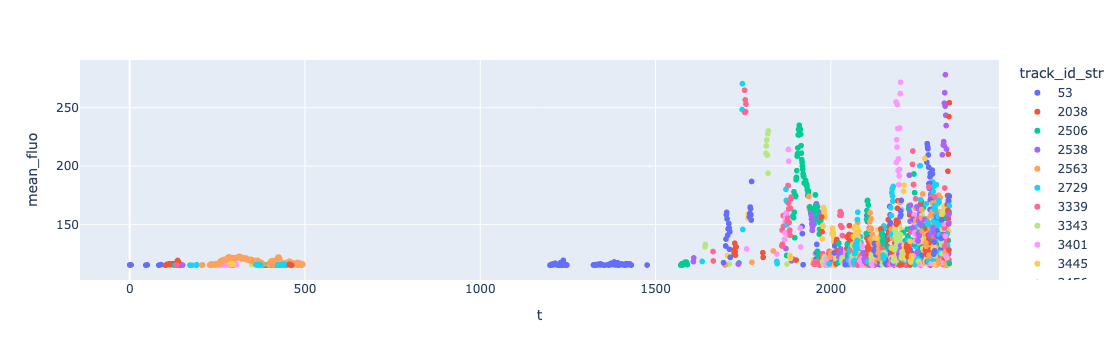

In [29]:
fluo_thresh = 115

bright_tracks = tracks_df.loc[tracks_df["mean_fluo"] > fluo_thresh, "track_id"]

ti, tc = np.unique(bright_tracks, return_counts=True)
candidate_tracks = ti[tc>0]

tracks_df["track_id_str"] = tracks_df["track_id"].astype(str)

# fig = px.scatter(tracks_df.loc[np.isin(tracks_df["track_id"], candidate_tracks)], x="t", y="mean_fluo", color="track_id_str")
fig = px.scatter(tracks_df.loc[tracks_df["mean_fluo"]>fluo_thresh], x="t", y="mean_fluo", color="track_id_str")
fig.show()

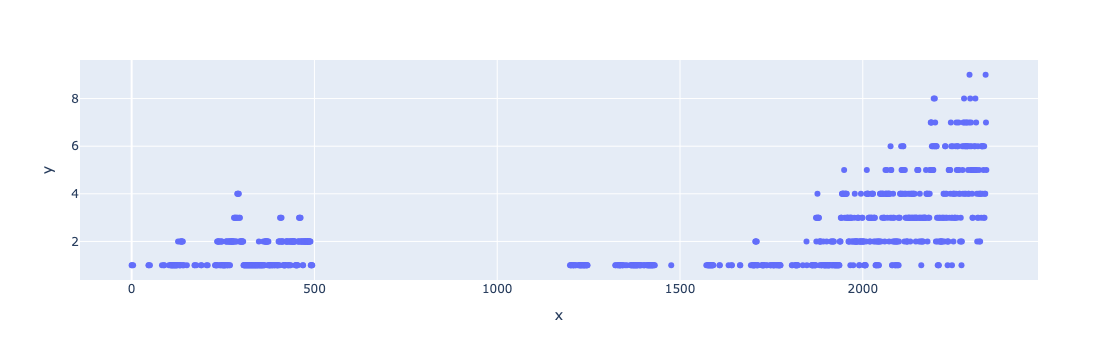

In [30]:
fi, fc = np.unique(tracks_df.loc[tracks_df["mean_fluo"]>fluo_thresh, "t"], return_counts=True)

fig = px.scatter(x=fi, y=fc)
fig.show()

In [23]:
tia, tca = np.unique(tracks_df["track_id"], return_counts=True)
np.sum(tca**2) / np.sum(tca)

np.float64(322.9917977509123)